In [1]:
import numpy as np
from tqdm import tqdm, trange
from scipy.sparse import coo_matrix, hstack,vstack
from scipy.interpolate import griddata

from scipy.optimize import fsolve
from scipy import integrate
import sympy as sp
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
import time
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import deepxde as dde
from timeit import default_timer
import datetime
import os
import joblib
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt
from pde_control_gym.src import TunedReward1D
import pde_control_gym
from sklearn.preprocessing import StandardScaler
print("DeepXDE版本:", dde.__version__)


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


DeepXDE版本: 1.13.2


In [ ]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)
# 以下函数与 1.py 中的函数保持一致
# 以下函数与 1.py 中的函数保持一致

def solveBetaFunction(x, gamma):
    beta = np.zeros(len(x), dtype=np.float32)
    for idx, val in enumerate(x):
        beta[idx] = 5 * math.cos(gamma * math.acos(val))
    return beta
def getInitialCondition(nx):
    return (np.ones(nx)*np.random.uniform(1, 10))

# NO NOISE
def noiseFunc(state):
    return state

# Kernel function solver for backstepping
def solveKernelFunction(theta):
    kappa = np.zeros(len(theta))
    for i in range(0, len(theta)):
        kernelIntegral = 0
        for j in range(0, i):
            kernelIntegral += (kappa[i-j]*theta[j])*dx
        kappa[i] = kernelIntegral - theta[i]
    return np.flip(kappa)

# Control convolution solver
def solveControl(kernel, u):
    res = 0
    for i in range(len(u)):
        res += kernel[i]*u[i]
    return res*1e-2

# 修改后的 getBetaFunction
def getBetaFunction(nx,lamArr):
    
    return solveBetaFunction(np.linspace(0, 1, nx), lamArr)


def datasetGenerate(num,num2, spatial, finalTime, tTotal, control_sample_rate):
    uarr = []  # 存储所有时间步的状态+λ
    U_true_arr = []  # 存储每个时间步的控制器输出
    # 使用与 1.py 相同的 dt 和 dx
    dt = 0.001
    dx = 0.01
    T = finalTime
    nt = tTotal 
    pbar = tqdm(total=nt)
    for i in range(num):
        
        lamArr = np.random.uniform(6,7.5)
        
        
        
        
        lam = solveBetaFunction(spatial, lamArr)  # 确保 lamTemp 的长度为 nx+1
        kernel = solveKernelFunction(lam)
        for j in range(num2):
            hyperbolicParameters = {
                   "T": T,
                   "dt": dt,
                   "X": 1,
                   "dx": dx,
                   "lamArr":lamArr,
                   "reward_class": TunedReward1D(int(round(T / dt)), -1e3, 3e2),
                   "normalize": False,
                   "sensing_loc": "full",
                   "control_type": "Dirchilet",
                   "sensing_type": None,
                   "sensing_noise_func": lambda state: state,
                   "limit_pde_state_size": True,
                   "max_state_value": 1e10,
                   "max_control_value": 20,
                   "reset_init_condition_func": getInitialCondition,
                   "reset_recirculation_func": getBetaFunction,
                   "control_sample_rate": control_sample_rate,
            }

            env = gym.make("PDEControlGym-TransportPDE1D", **hyperbolicParameters)
            obs, _ = env.reset()
            terminate = False
            truncate = False
            
    

    
    
            while not truncate and not terminate:
                
                uarr.append(obs)
                
                action = solveControl(kernel, obs[101:])
                
               
                U_true_arr.append(action)
                    
                obs, rewards, terminate, truncate, info = env.step(action)
                pbar.update(1)
                
    
    pbar.close()
    
    x = np.array(uarr, dtype=np.float32)  # 输入：(样本数, nx+1)
    y = np.array(U_true_arr, dtype=np.float32)    # 输出：(样本数, 1)

    np.savetxt("hx_controll.dat", x)
    np.savetxt("hy_controll.dat", y)



In [3]:
X = 1
dx = 0.01
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx+1, dtype=np.float32)
N1 = len(spatial)
N = N1 - 1                  
# Parameters of NN
epochs =450
ntrain = 900
ntest = 100
gamma = 0.5
learning_rate = 1e-4
step_size= 40
modes=12
width=32
batch_size =50


In [4]:
timeTest = 5
pointTest = 5001
recount = True

In [ ]:
if recount == True:
    datasetGenerate(100,60, spatial, timeTest, pointTest, 0.1)
    print("Date is ", datetime.datetime.now())

600000it [01:50, 5445.78it/s]                        


Date is  2025-06-15 11:03:17.897767


In [ ]:
sub_xy = 1
# 加载输入数据（状态+λ）
inpArr1 = np.loadtxt("hx_controll.dat", dtype=np.float32)  
# 加载标签数据（控制器输出，正确文件路径）
outArr = np.loadtxt("hy_controll.dat", dtype=np.float32)  

# 处理输入数据：采样并保持二维形状 [样本数, 204]
xxx = inpArr1[::sub_xy, :]  
# 处理标签数据：采样并压缩为一维 [样本数]
yyy = outArr[::sub_xy].reshape(-1)  

# 验证数据形状
print(f"xxx形状: {xxx.shape}")       # 应输出 (600000, 204)
print(f"yyy形状: {yyy.shape}")       # 应输出 (600000,)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    xxx, yyy, test_size=0.1, random_state=1
)

# 转换为PyTorch张量（标签为一维）
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()   # 形状：[540000]
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()    # 形状：[60000]
print("x_train 前5行数据值:\n", x_train[100:101].cpu().numpy()) # 将 GPU 张量移到 CPU 并转成 NumPy 数组
print("y_train 前5行数据值:\n", y_train[100:101].cpu().numpy())

# 查看 x_test 和 y_test 前5行数据值（可选）
print("x_test 前5行数据值:\n", x_test[100:101].cpu().numpy())
print("y_test 前5行数据值:\n", y_test[100:101].cpu().numpy())
# 打印最终形状
print(f"x_train形状: {x_train.shape}")  # 输出 torch.Size([540000, 204])
print(f"y_train形状: {y_train.shape}")  # 输出 torch.Size([540000])
trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

xxx形状: (600000, 202)
yyy形状: (600000,)
x_train 前5行数据值:
 [[-4.92758656e+00 -4.97015667e+00 -4.99418831e+00 -4.99958515e+00
  -4.98631382e+00 -4.95440340e+00 -4.90394449e+00 -4.83509064e+00
  -4.74805641e+00 -4.64311981e+00 -4.52061796e+00 -4.38094997e+00
  -4.22457552e+00 -4.05201149e+00 -3.86383414e+00 -3.66067624e+00
  -3.44322658e+00 -3.21222734e+00 -2.96847391e+00 -2.71281242e+00
  -2.44613814e+00 -2.16939354e+00 -1.88356614e+00 -1.58968568e+00
  -1.28882289e+00 -9.82085824e-01 -6.70617878e-01 -3.55594575e-01
  -3.82208228e-02  2.80272335e-01  5.98630905e-01  9.15581524e-01
   1.22983456e+00  1.54008853e+00  1.84503305e+00  2.14335370e+00
   2.43373561e+00  2.71486759e+00  2.98544741e+00  3.24418497e+00
   3.48980904e+00  3.72106957e+00  3.93674493e+00  4.13564587e+00
   4.31662130e+00  4.47856379e+00  4.62041473e+00  4.74116993e+00
   4.83988667e+00  4.91568851e+00  4.96777296e+00  4.99541569e+00
   4.99797869e+00  4.97491646e+00  4.92578316e+00  4.85023928e+00
   4.74805737e+00  4.

In [5]:
nx=100
spatial = np.linspace(0, X, nx+1, dtype=np.float32)
grid_1d = spatial.reshape(-1, 1)  
grid2 = torch.from_numpy(grid_1d).cuda()
print(grid2.shape)
class BranchNet(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape 
        self.conv1 = torch.nn.Conv1d(in_channels=2, out_channels=32,  kernel_size=5,stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5,stride=2)
       
        self.fc1 = torch.nn.Linear(64 * 23, 101)
        
        self.relu = nn.ReLU()
  
    def forward(self, x):
        
        x = x.reshape(x.shape[0], 2, self.shape)  # 正确重塑为二维通道+一维空间
        x = self.conv1(x)  
        x = self.relu(x)
        x = self.conv2(x) 
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)  
        x = self.fc1(x)
        
        x = self.relu(x)
        
        return x
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
class DeepONetModified(nn.Module):
    def __init__(self, m2, branch_2dim, dim_x, projection):#project=1
        super(DeepONetModified, self).__init__()
        self.net1 = dde.nn.DeepONetCartesianProd([m2, branch_2dim], [dim_x, 32,64,101], "relu", "Glorot normal").cuda()
        self.fc3 = torch.nn.Linear(101, 64)
        self.relu = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(64, 32)
        self.fc5 = torch.nn.Linear(32, projection)
        

    def forward(self, x):
        x, grid = x[0], x[1]
        x = self.net1((x, grid))
        x = self.relu(self.fc3(x))
        
        x = self.relu(self.fc4(x))
        return self.fc5(x)
m2 = nx+1
projection = 1
model = DeepONetModified(m2, BranchNet(nx+1),  1, projection).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


torch.Size([101, 1])


In [ ]:
#loss = torch.nn.MSELoss()
loss = torch.nn.SmoothL1Loss(reduction='mean', beta=1.0)
train_lossArr = []
test_lossArr = []
time_Arr = []

print("strat to train~~")
for ep in trange(450):
    t1 = default_timer()
    model.train()
    train_loss = 0
    for xxTemp, yyTemp in trainData:
        xx, y1 = xxTemp.cuda(), yyTemp.cuda()
        optimizer.zero_grad()

        out = model((xx, grid2))

        #print(f"out shape: {out.shape}, y1 shape: {y1.shape}")
        lp = loss(out.view(batch_size, -1), y1.view(batch_size, -1))
        lp.backward()

        optimizer.step()
        train_loss += lp.item()

    scheduler.step()

    model.eval()
    test_loss = 0
    with torch.no_grad():  # 测试集
        for xxTemp, yyTemp in testData:
            xx, y1 = xxTemp.cuda(), yyTemp.cuda()
            out = model((xx, grid2))
            test_loss += loss(out.view(batch_size, -1), y1.view(batch_size, -1)).item()

    train_loss /= len(trainData)
    test_loss /= len(testData)

    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)

    t2 = default_timer()
    time_Arr.append(t2 - t1)
    if ep % 50 == 0:
        print(ep, t2 - t1, train_loss, test_loss)

print("end")

# 保存模型参数
torch.save(model.state_dict(), "modedlNeth2.pt")


strat to train~~


  0%|          | 1/450 [00:23<2:59:13, 23.95s/it]

0 23.950287005049177 0.043699658008066494 0.004024620746495202


 11%|█▏        | 51/450 [20:21<2:39:44, 24.02s/it]

50 24.374697491060942 0.00028055552360995166 0.00017697868162031227


 22%|██▏       | 101/450 [40:13<2:18:22, 23.79s/it]

100 24.219186137081124 0.00013782487131476485 0.0001296007843878518


 34%|███▎      | 151/450 [1:00:10<2:00:30, 24.18s/it]

150 24.557656407007016 8.14637791787239e-05 7.023594887982654e-05


 45%|████▍     | 201/450 [1:19:49<1:35:39, 23.05s/it]

200 23.751429872005247 5.2159423652129694e-05 5.0321777488306905e-05


 56%|█████▌    | 251/450 [1:39:02<1:15:55, 22.89s/it]

250 22.555721045006067 4.724779454837365e-05 4.8716864516412294e-05


 67%|██████▋   | 301/450 [1:58:06<57:55, 23.33s/it]  

300 23.36839079798665 4.47119591816587e-05 4.452596822773103e-05


 78%|███████▊  | 351/450 [2:17:33<39:12, 23.76s/it]

350 24.322822486050427 4.367520884321257e-05 4.403544030878948e-05


 89%|████████▉ | 401/450 [2:36:56<19:19, 23.66s/it]

400 23.744542521075346 4.281560163557667e-05 4.311325385174314e-05


100%|██████████| 450/450 [2:55:57<00:00, 23.46s/it]

end


<Figure size 800x600 with 0 Axes>

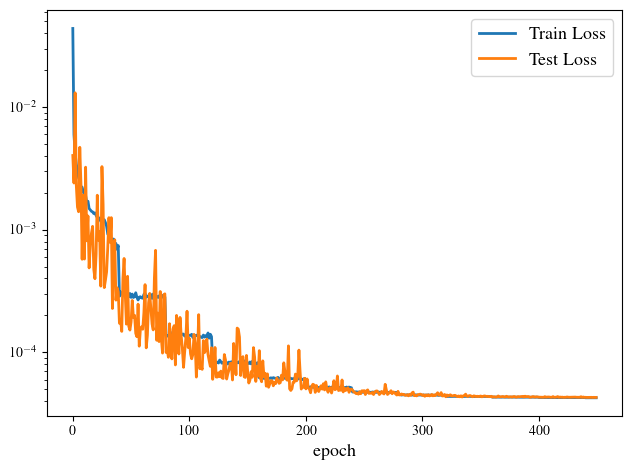

In [28]:
my_dpi = 600
fig = plt.figure(figsize=(800 / my_dpi, 600 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False
flg, ax = plt.subplots()
ax.plot(train_lossArr, label="Train Loss", linewidth=2)
ax.plot(test_lossArr, label="Test Loss", linewidth=2)

plt.xlabel('epoch',fontsize="13")
plt.tick_params(labelsize=10)
fig = plt.gcf()
fig.tight_layout()
plt.legend(fontsize="13", loc="best")
plt.yscale("log")
#plt.ylim(1e-7, 1e+01)
#plt.savefig('../picture2/9_25/trainLoss.jpg', dpi=500,bbox_inches='tight')
plt.show()



In [13]:

#model2 = DeepONetModified(m2, BranchNet(nx+1),  2, projection).cpu()
model2 = DeepONetModified(nx+1, BranchNet(nx+1),  1, projection).cpu()
if os.path.exists("modedlNeth2.pt"):
    model2.load_state_dict(torch.load("modedlNeth2.pt", map_location = 'cpu'))
    print("model on device：", next(model2.parameters()).device)
    print("success！")
#print("success！")  
girdEstimate = grid2.cpu()


model on device： cpu
success！


lam 5.7
x_train形状: (101, 101)
ain形状: (100,)


[Text(-14.0, 0, '-14'),
 Text(-5.0, 0, '-5'),
 Text(3.0, 0, '3'),
 Text(11.0, 0, '11'),
 Text(20.0, 0, '20')]

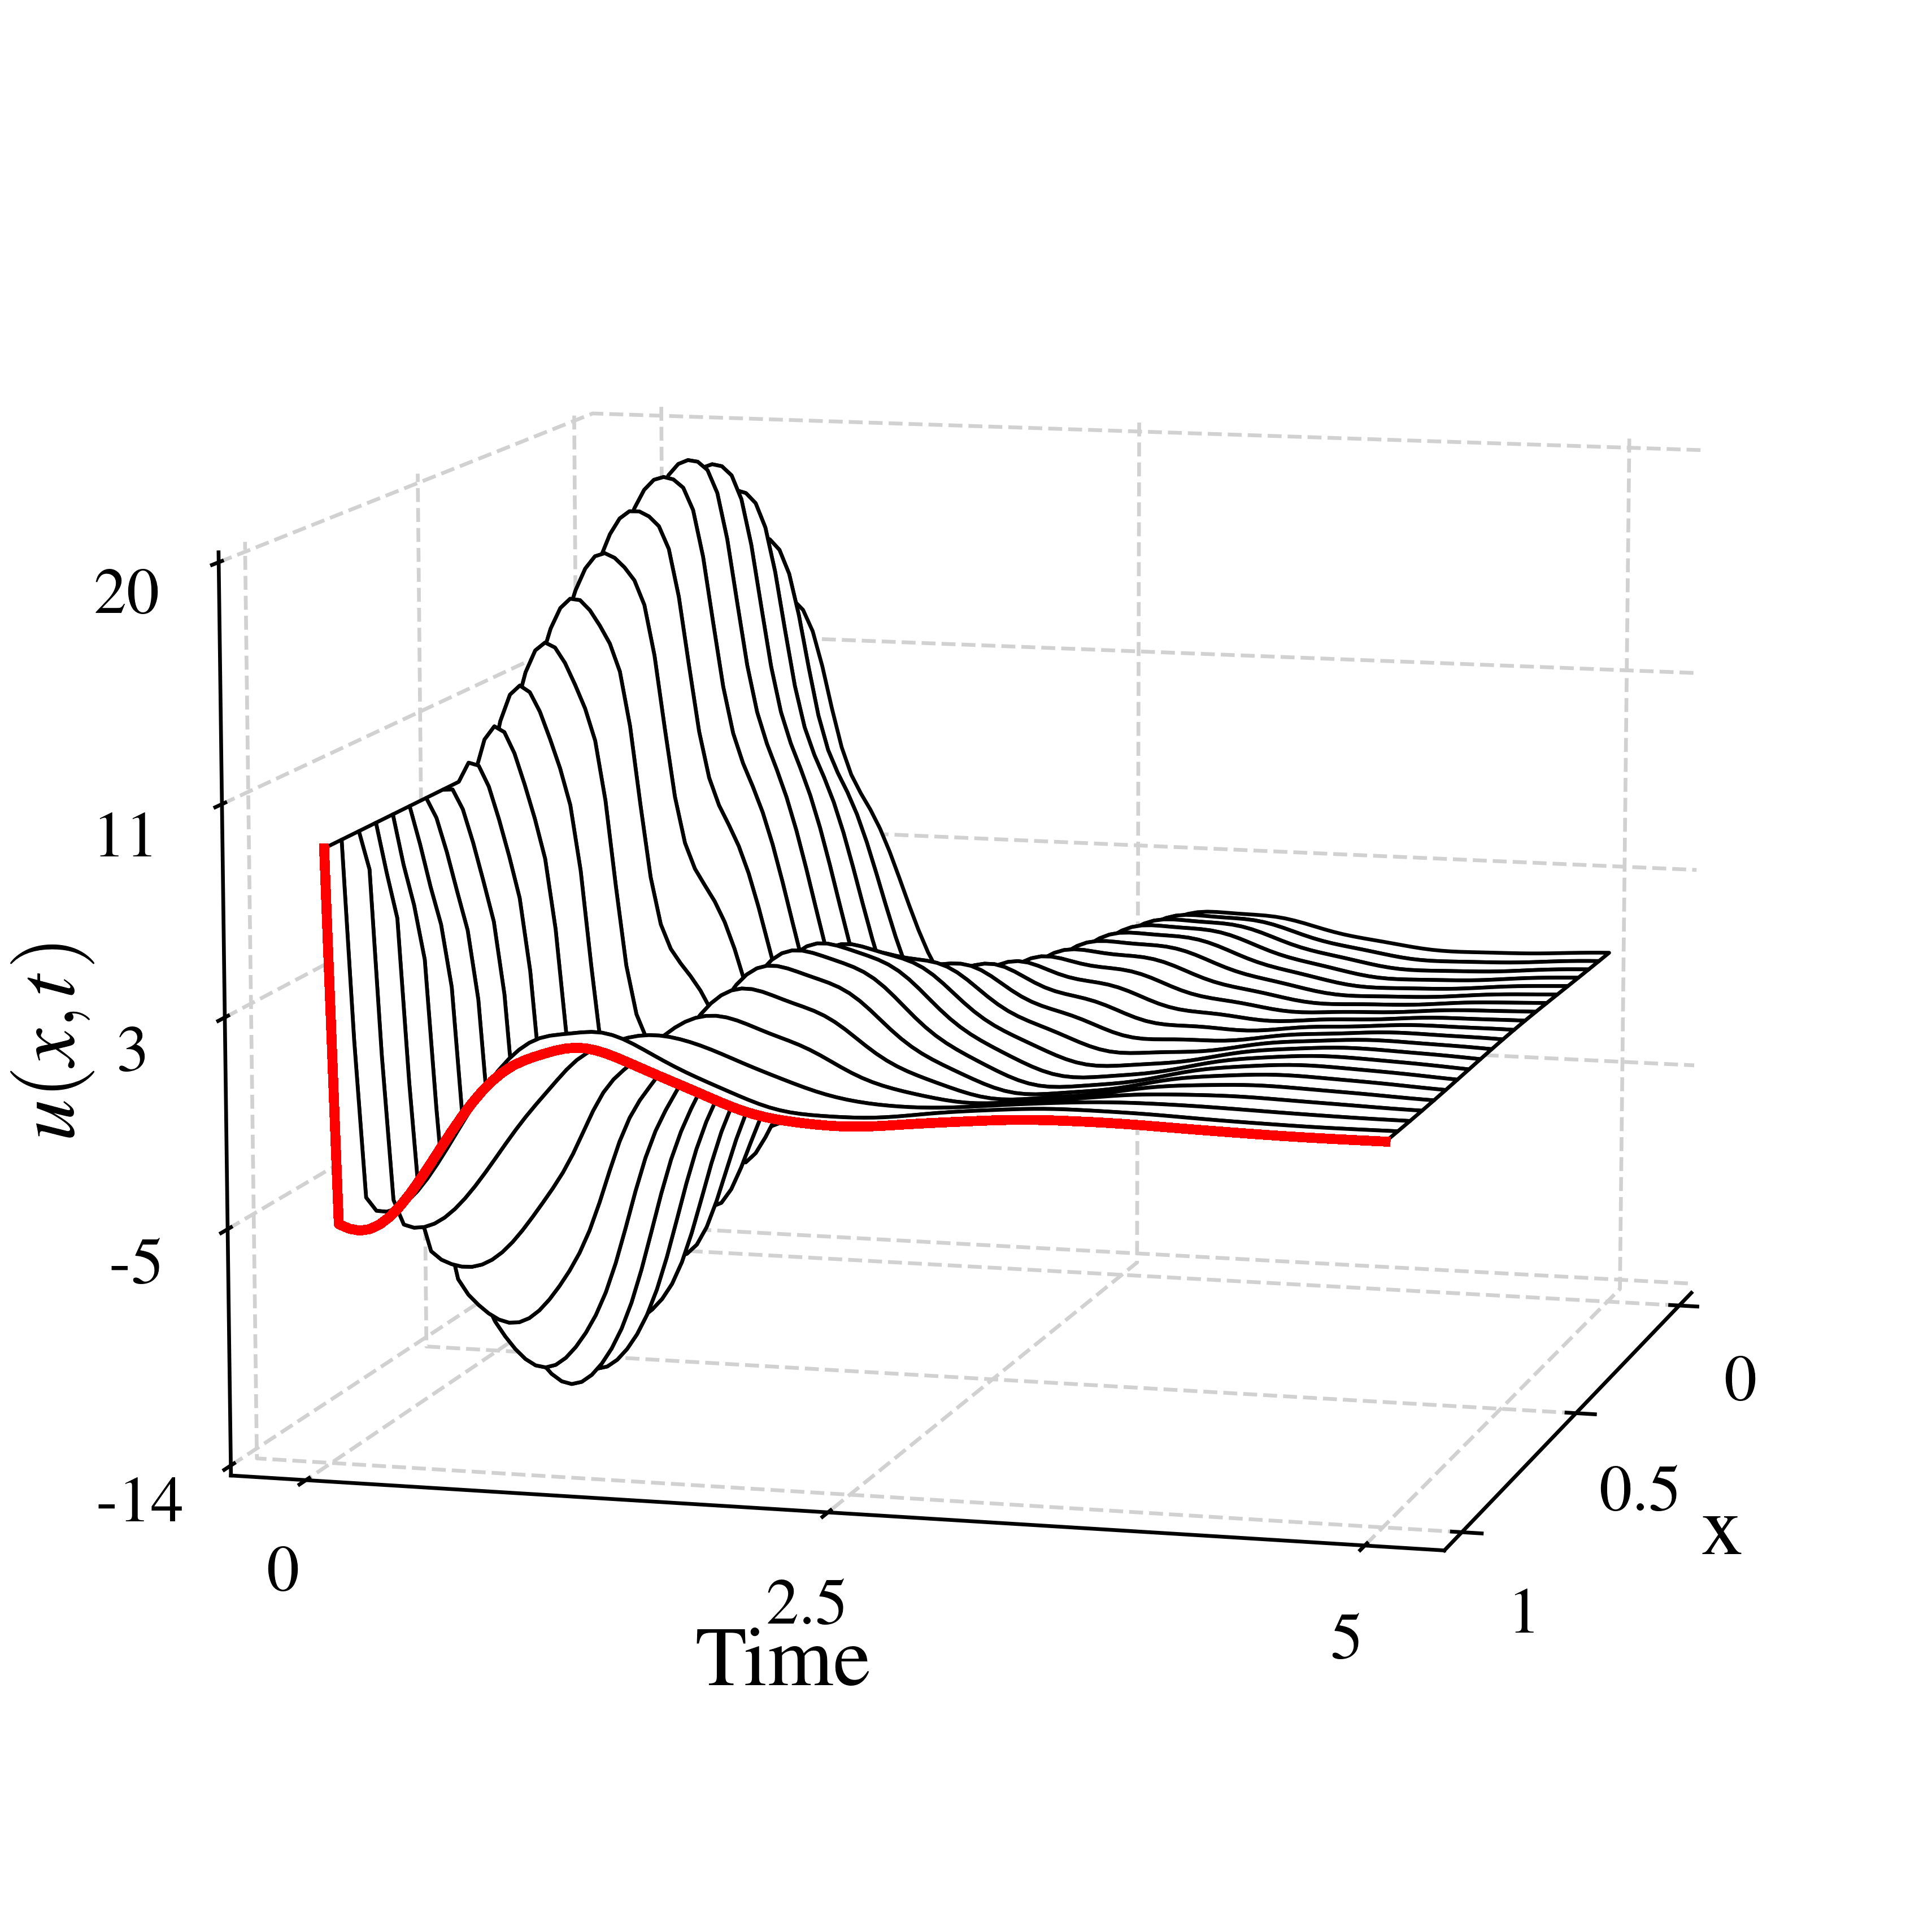

In [20]:
# 修改后的 getBetaFunction
def getBetaFunction(nx,lamArr):
    
    return solveBetaFunction(np.linspace(0, 1, nx), lamArr)
def getInitialCondition1(nx):
    return np.ones(nx) *9

# Timestep and spatial step for PDE Solver
T = 5
dt = 0.001
dx = 0.01
X = 1
lamArr=5.7
hyperbolicParameters = {
    "T": T,
    "dt": dt,
    "X": X,
    "dx": dx,
    "lamArr":lamArr,
    "reward_class": TunedReward1D(int(round(T / dt)), -1e3, 3e2),
    "normalize": False,
    "sensing_loc": "full",
    "control_type": "Dirchilet",
    "sensing_type": None,
    "sensing_noise_func": lambda state: state,
    "limit_pde_state_size": True,
    "max_state_value": 1e10,
    "max_control_value": 20,
    "reset_init_condition_func": getInitialCondition1,
    "reset_recirculation_func": getBetaFunction,  # 使用修改后的函数
    "control_sample_rate": 0.05,
}

# Make the hyperbolic PDE gym
env_U = gym.make("PDEControlGym-TransportPDE1D", **hyperbolicParameters)
obs_U, __ = env_U.reset()
# Run a single environment test case for gamma=8
terminate = False
truncate = False
nt = int(round(X / dx))
x = np.linspace(0, 1, nt + 1)

# Holds the resulting states
control_U = []
state_U=[]
# Reset Environment


state_U.append(obs_U[101:])

spatial = np.linspace(dx, X, int(round(X / dx) + 1))
kernel = solveKernelFunction(solveBetaFunction(spatial,5.5))
print("lam", lamArr)
i = 0
rew = 0
while not truncate and not terminate:

    action = solveControl(kernel, obs_U[101:])
    obs_U, rewards, terminate, truncate, info = env_U.step(action)
    control_U.append(action)
    #print(f"Time step : Controller value = {control_U}")
    state_U.append(obs_U[101:])
    #print(f"Time step : Controller value = {state_U}")
    
u= np.array(state_U)
print(f"x_train形状: {u.shape}") 
U=np.array(control_U)
print(f"ain形状: {U.shape}") 
# Plot the example
res = 1
fig = plt.figure(figsize=(6,5),dpi=600)
spatial = np.linspace(dx, X, int(round(X / dx) + 1))
temporal = np.linspace(0, T, len(state_U))
temporal1 = np.linspace(0, T, len(control_U))



# ---------------------- 子图布局：缩小白框 ----------------------
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)


# 关键修改：收紧边距（left/bottom增大，right/top减小）
subfig = subfigs
# ---------------------- 关键：收紧边距 ----------------------
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
#plt.title('backstepping-u(x,0)=9-lam=5.5')
for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 10
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.8
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
# 2. 设置z轴标签（增大字体并调整位置）
# 3. 加粗所有轴的刻度标签（数字）
# 2. 缩小边距：left/bottom 增大（减少左侧/底部空白），right/top 减小（减少右侧/顶部空白）

meshx, mesht = np.meshgrid(spatial, temporal)

axes.plot_surface(meshx, mesht, u, edgecolor="black", lw=0.8, rstride=500, cstride=5,
                  alpha=1, color="white", shade=False, rasterized=True, antialiased=True)

# 添加红线：x=1位置处的状态随时间的变化
test = np.ones(len(temporal))  # 创建x=1的位置数组
vals = (u.transpose())[-1]   # 提取x=1处的所有时间步的状态值
axes.plot(test, temporal, vals, color="red", lw=2, antialiased=False, rasterized=False)

axes.view_init(10, 15)
axes.set_xlabel("x",fontsize=18,labelpad=5,fontweight='bold')
axes.set_ylabel("Time",fontsize=18,labelpad=5,fontweight='bold')
axes.set_zlabel(r"$u(x, t)$", rotation=90,fontsize=18,labelpad=1,fontweight='bold' )
axes.zaxis.set_rotate_label(False)
  # 动态计算z轴刻度（避免固定值超出范围）
z_min, z_max = np.min(u), np.max(u)
z_ticks = np.linspace(z_min, z_max, 5).round()  # 生成5个均匀刻度
axes.set_zticks(z_ticks)
    
axes.set_xticks([0, 0.5, 1])
axes.set_yticks([0, 2.5, 5])
axes.set_xticklabels(['0', '0.5', '1'], fontweight='bold', fontsize=14)
axes.set_yticklabels(['0', '2.5', '5'], fontweight='bold', fontsize=14)
axes.set_zticklabels([f"{tick:.0f}" for tick in z_ticks], fontweight='bold', fontsize=14)


[Text(-5, 0, '-5'),
 Text(0, 0, '0'),
 Text(5, 0, '5'),
 Text(10, 0, '10'),
 Text(15, 0, '15')]

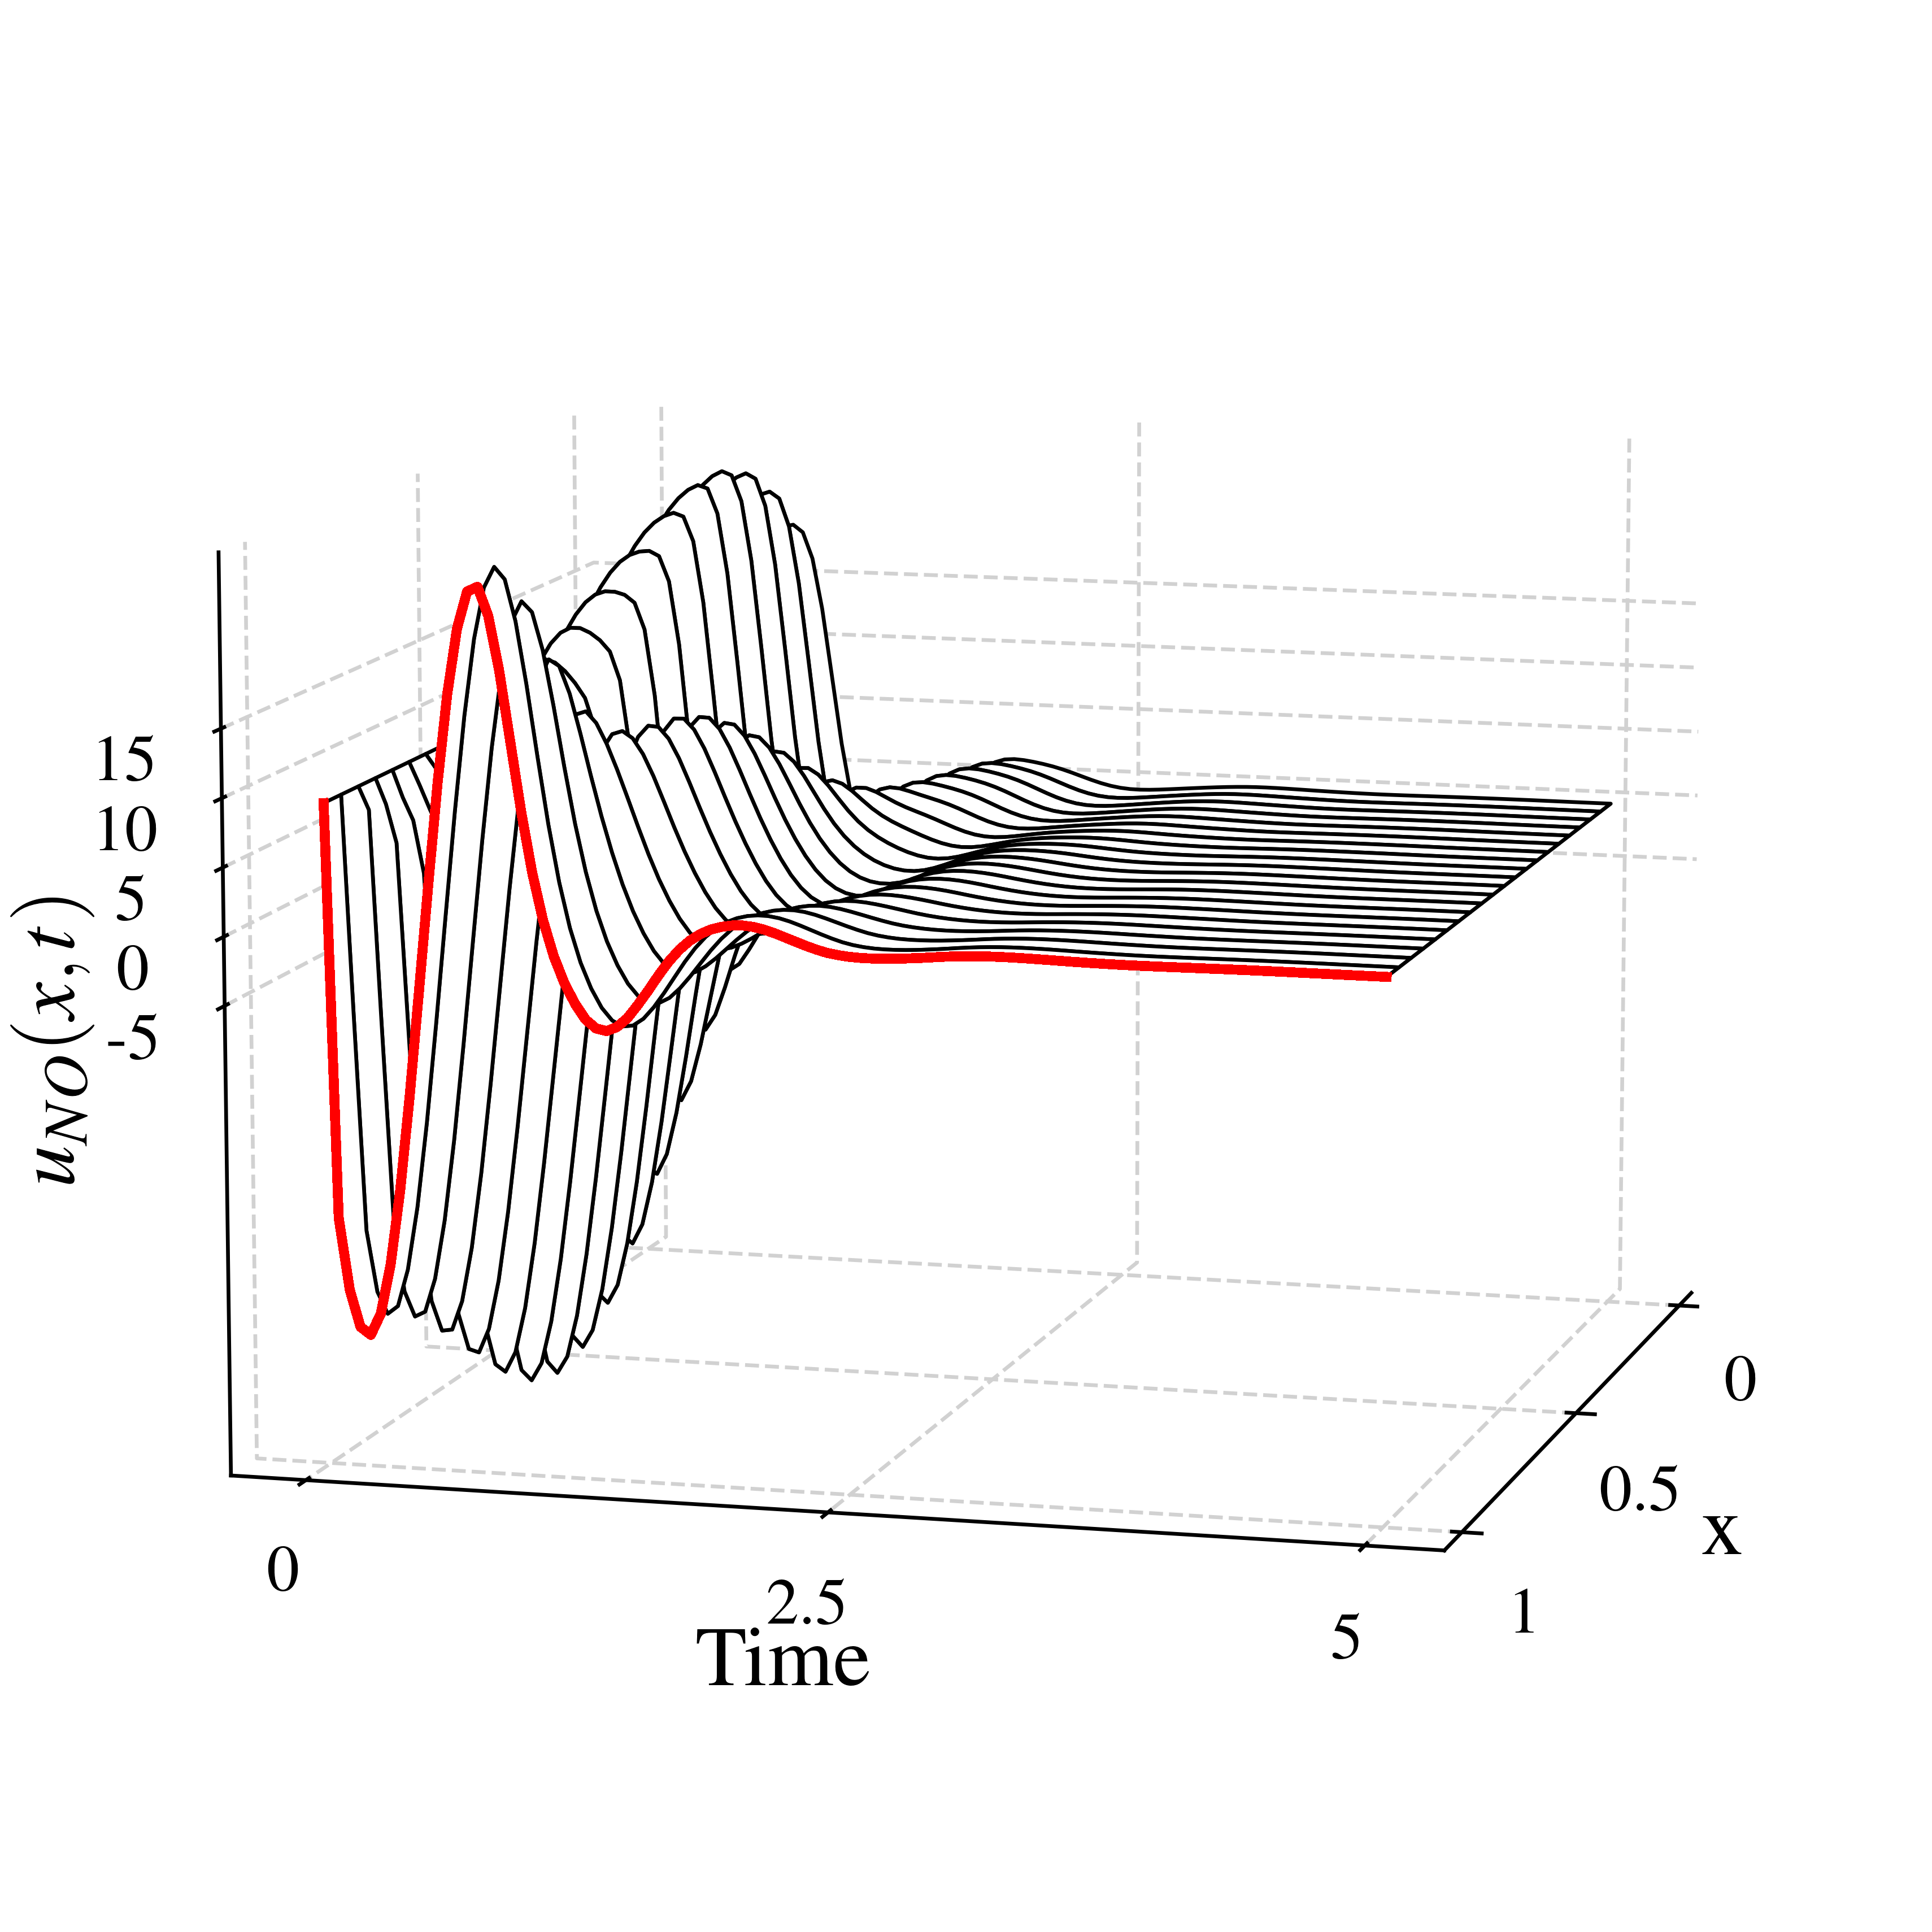

In [ ]:

def getInitialCondition1(nx):
    return np.ones(nx ) *9
T1 = 5

lamArr =5.5
dt = 0.001
nt = int(T1 / dt) + 1
dx = 0.01
nx = int(1 / dx)
spatial = np.linspace(dx, 1, nx + 1, dtype=np.float32)

# 生成传统控制器的核函数（U）
beta = solveBetaFunction(spatial, lamArr)
kernel = solveKernelFunction(beta)
hyperbolicParameters = {
    "T": T1,
    "dt": dt,
    "X": 1,
    "dx": dx,
    "lamArr": lamArr,
    "reward_class": TunedReward1D(int(round(T1 / dt)), -1e3, 3e2),
    "normalize": False,
    "sensing_loc": "full",
    "control_type": "Dirchilet",
    "sensing_type": None,
    "sensing_noise_func": lambda state: state,
    "limit_pde_state_size": True,
    "max_state_value": 1e10,
    "max_control_value":20,
    "reset_init_condition_func": getInitialCondition1,
    "reset_recirculation_func": getBetaFunction,
    "control_sample_rate": 0.05,
}

env_UNO = gym.make("PDEControlGym-TransportPDE1D", **hyperbolicParameters)
obs_UNO, _ = env_UNO.reset()

# 收集两种控制器的输出
control_UNO = []
state_UNO = []
state_UNO.append(obs_UNO[101:])
terminate = False
truncate = False

# 传统控制器
time_index = 0
#while time_index < nt - 1:
while not truncate and not terminate:

    with torch.no_grad():
         input_beta = beta.reshape(1, -1)        # (1, 22)
         input_state = obs_UNO[101:].reshape(1, -1)     # (1, 22)
    
         x_combined = np.hstack([input_beta, input_state])  # (1, 44)
         feature_tensor = torch.from_numpy(x_combined).float().cpu()
         action = model2((feature_tensor, girdEstimate)).numpy().flatten()  # 正确传递元组

    control_UNO.append(action)
    obs_UNO, rewards, terminate, truncate, info = env_UNO.step(action)
    state_UNO.append(obs_UNO[101:])
    time_index += 1

uNO= np.array(state_UNO)
UNO=np.array(control_UNO)
res = 1
fig = plt.figure(figsize=(6,5),dpi=600)
spatial = np.linspace(dx, X, int(round(X / dx) + 1))
temporal = np.linspace(0, T, len(state_U))
temporal1 = np.linspace(0, T, len(control_U))

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
#plt.title('backstepping-u(x,0)=9-lam=5.5')
for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 10
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.8
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
# 2. 设置z轴标签（增大字体并调整位置）
# 3. 加粗所有轴的刻度标签（数字）

# ... 前文代码保持不变 ...

meshx, mesht = np.meshgrid(spatial, temporal)

axes.plot_surface(meshx, mesht, uNO, edgecolor="black", lw=0.8, rstride=500, cstride=5,
                  alpha=1, color="white", shade=False, rasterized=True, antialiased=True)

# 添加红线：x=1位置处的状态随时间的变化
test = np.ones(len(temporal))  # 创建x=1的位置数组
vals = (uNO.transpose())[-1]   # 提取x=1处的所有时间步的状态值
axes.plot(test, temporal, vals, color="red", lw=2, antialiased=False, rasterized=False)

axes.view_init(10, 15)
axes.set_xlabel("x",fontsize=18,labelpad=5,fontweight='bold')
axes.set_ylabel("Time",fontsize=18,labelpad=5,fontweight='bold')
axes.set_zlabel(r"$u_{NO}(x, t)$", rotation=90,fontsize=18,labelpad=1,fontweight='bold' )
axes.zaxis.set_rotate_label(False)
  # 动态计算z轴刻度（避免固定值超出范围）
z_min, z_max = np.min(u), np.max(u)
z_ticks = np.linspace(z_min, z_max, 5).round()  # 生成5个均匀刻度
axes.set_zticks(z_ticks)
    
axes.set_xticks([0, 0.5, 1])
axes.set_yticks([0, 2.5, 5])
axes.set_xticklabels(['0', '0.5', '1'], fontweight='bold', fontsize=14)
axes.set_yticklabels(['0', '2.5', '5'], fontweight='bold', fontsize=14)
axes.set_zticklabels([f"{tick:.0f}" for tick in z_ticks], fontweight='bold', fontsize=14)


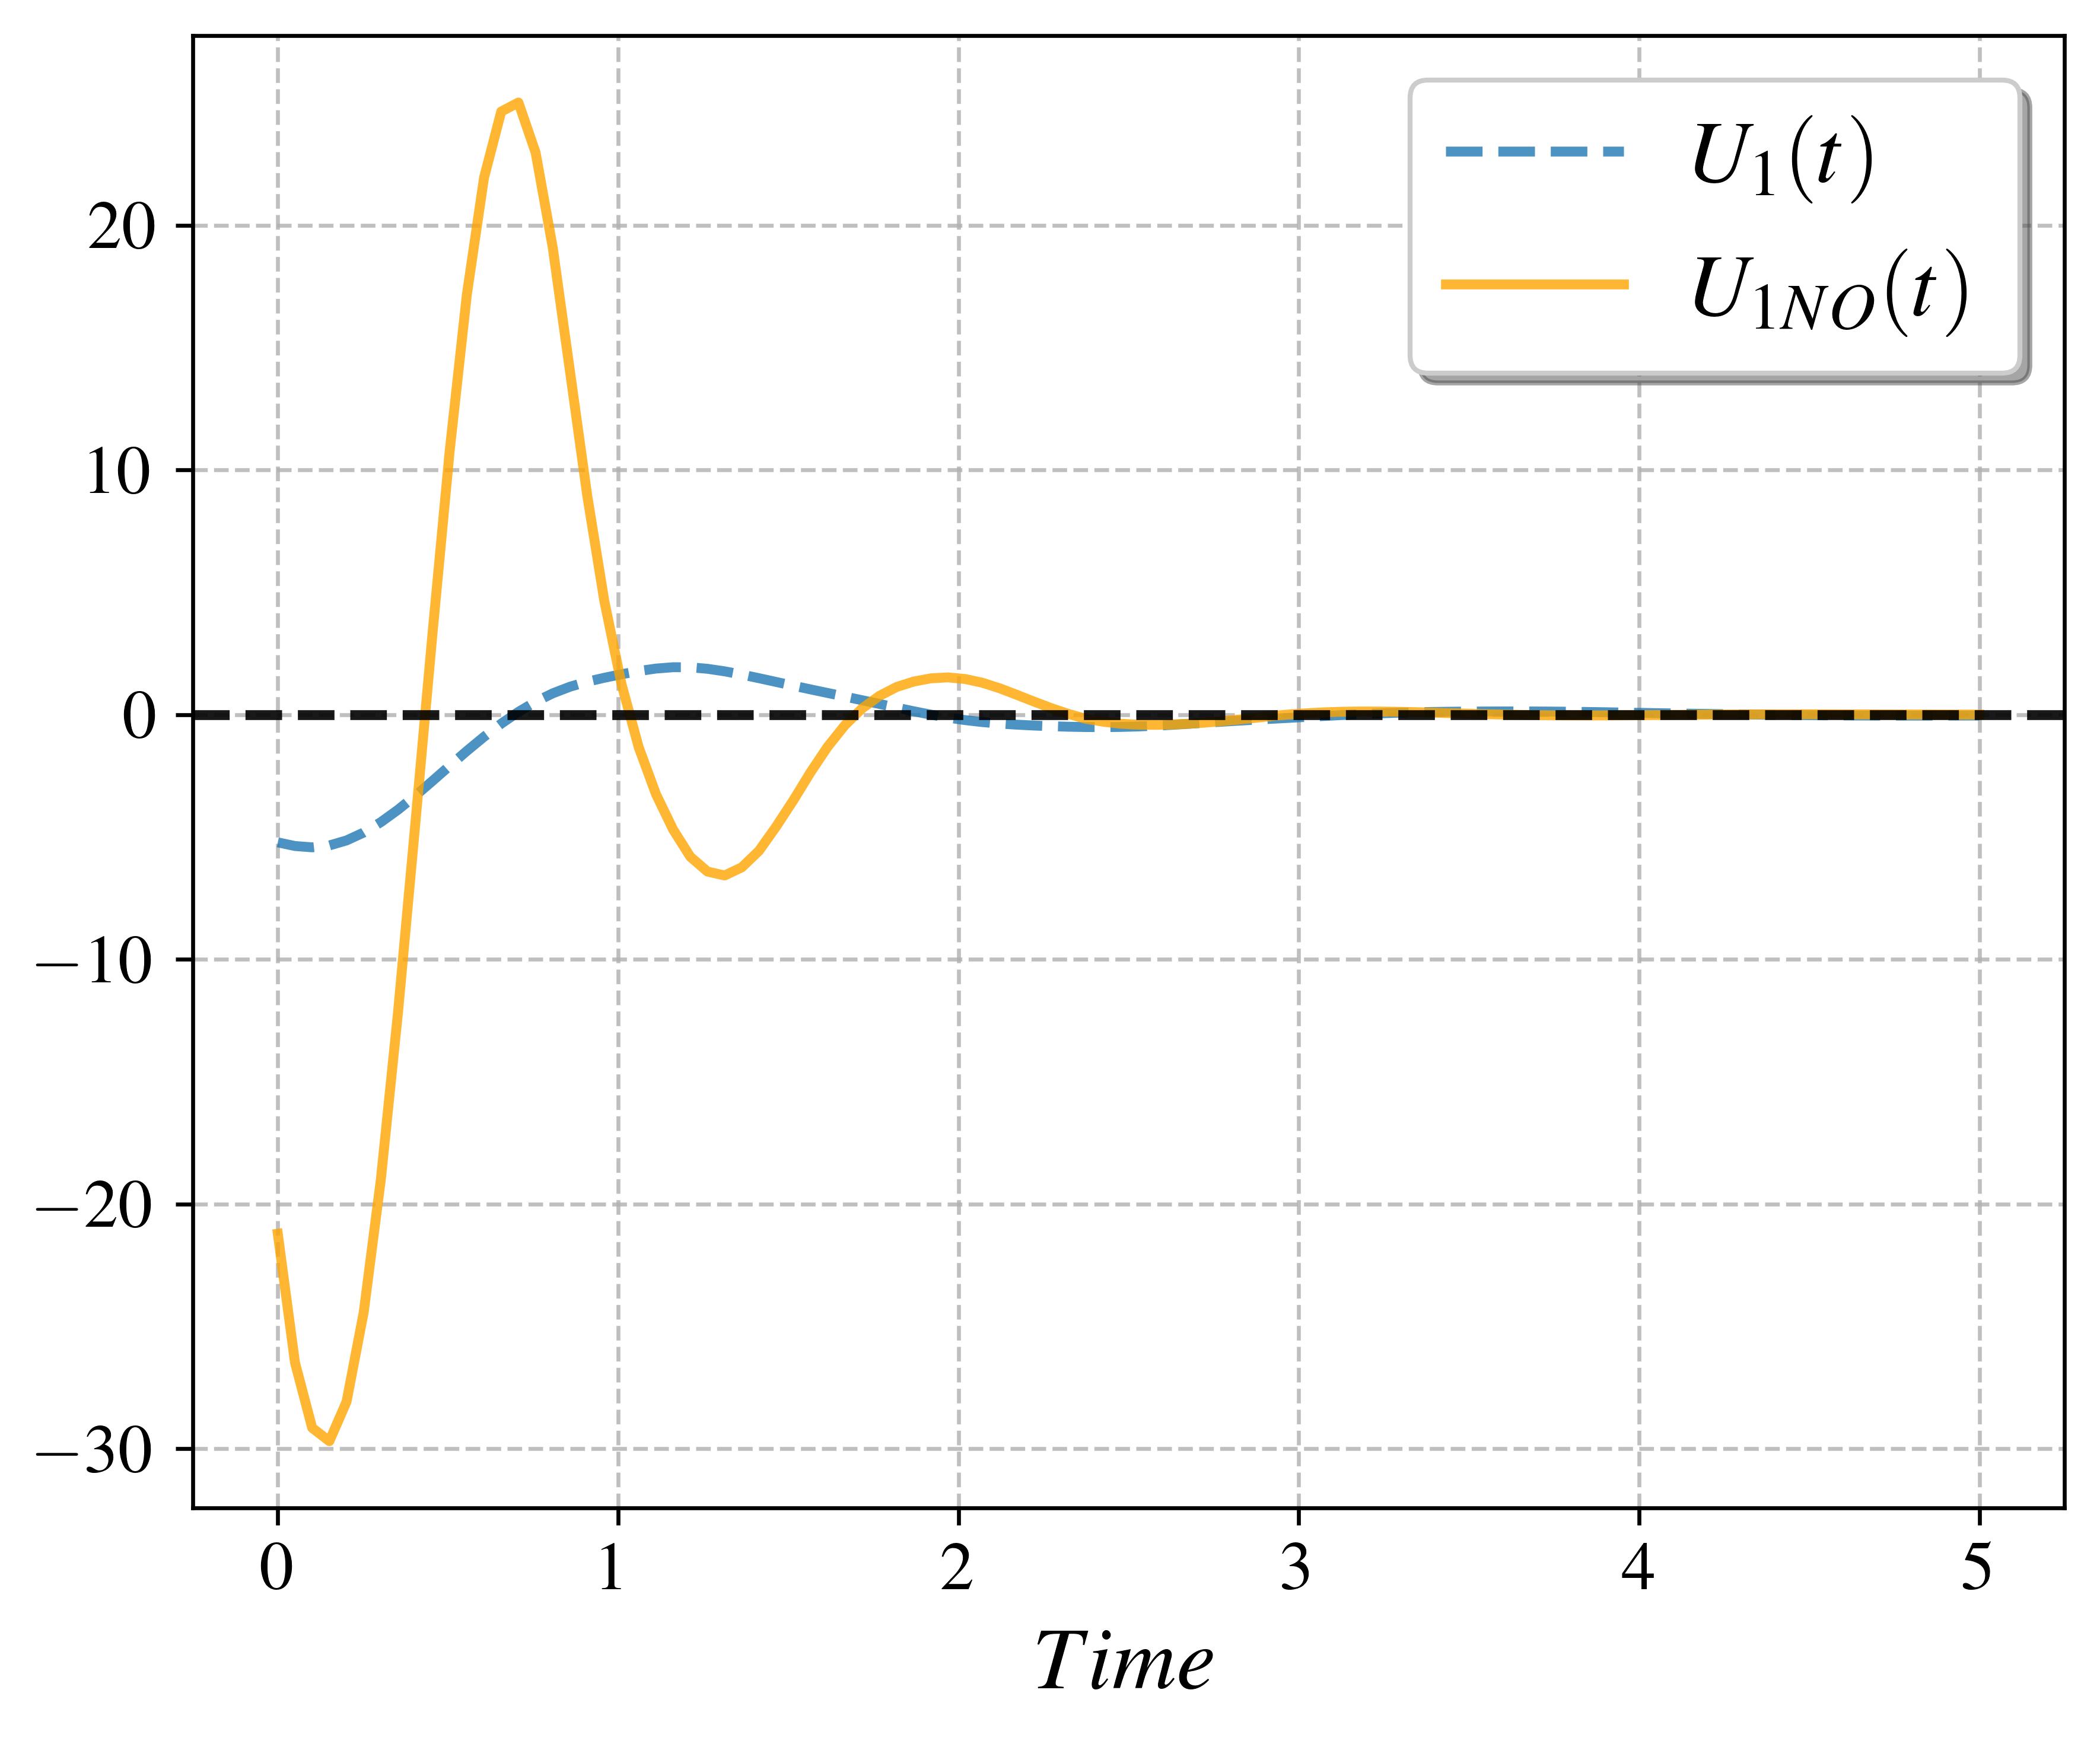

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 绘制L2范数对比图
temporal1 = np.linspace(0, T, len(control_U))
plt.figure(figsize=(6, 5),dpi=600)
plt.plot(temporal1, U, label='$U_1(t)$', linestyle='--', linewidth=2, alpha=0.8)
plt.plot(temporal1, UNO, label='$U_{1NO}(t)$', color='orange', linewidth=2, alpha=0.8)


# 添加纵轴0位置的虚线
plt.axhline(y=0, color='black', linestyle='--', alpha=0.9, linewidth=2)

# 设置坐标轴标签和字体大小
plt.xlabel(r"$Time$", fontsize=18, fontweight='bold', labelpad=5)
#plt.ylabel(r"$L_2\ \text{Norm of Difference}$", fontsize=14, fontweight='bold', labelpad=5)

# 刻度标签加粗
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')


# 显示图例（带阴影和边框）
plt.legend(fontsize=18, frameon=True, shadow=True)

# 添加背景网格
plt.grid(True, linestyle='--', alpha=0.8)

# 添加标题并调整布局
#plt.title("L2 Norm of State Comparison", fontsize=16)
plt.tight_layout()
#plt.title('u(x,0)=9-lam=5.5')
# 显示图形
plt.show()

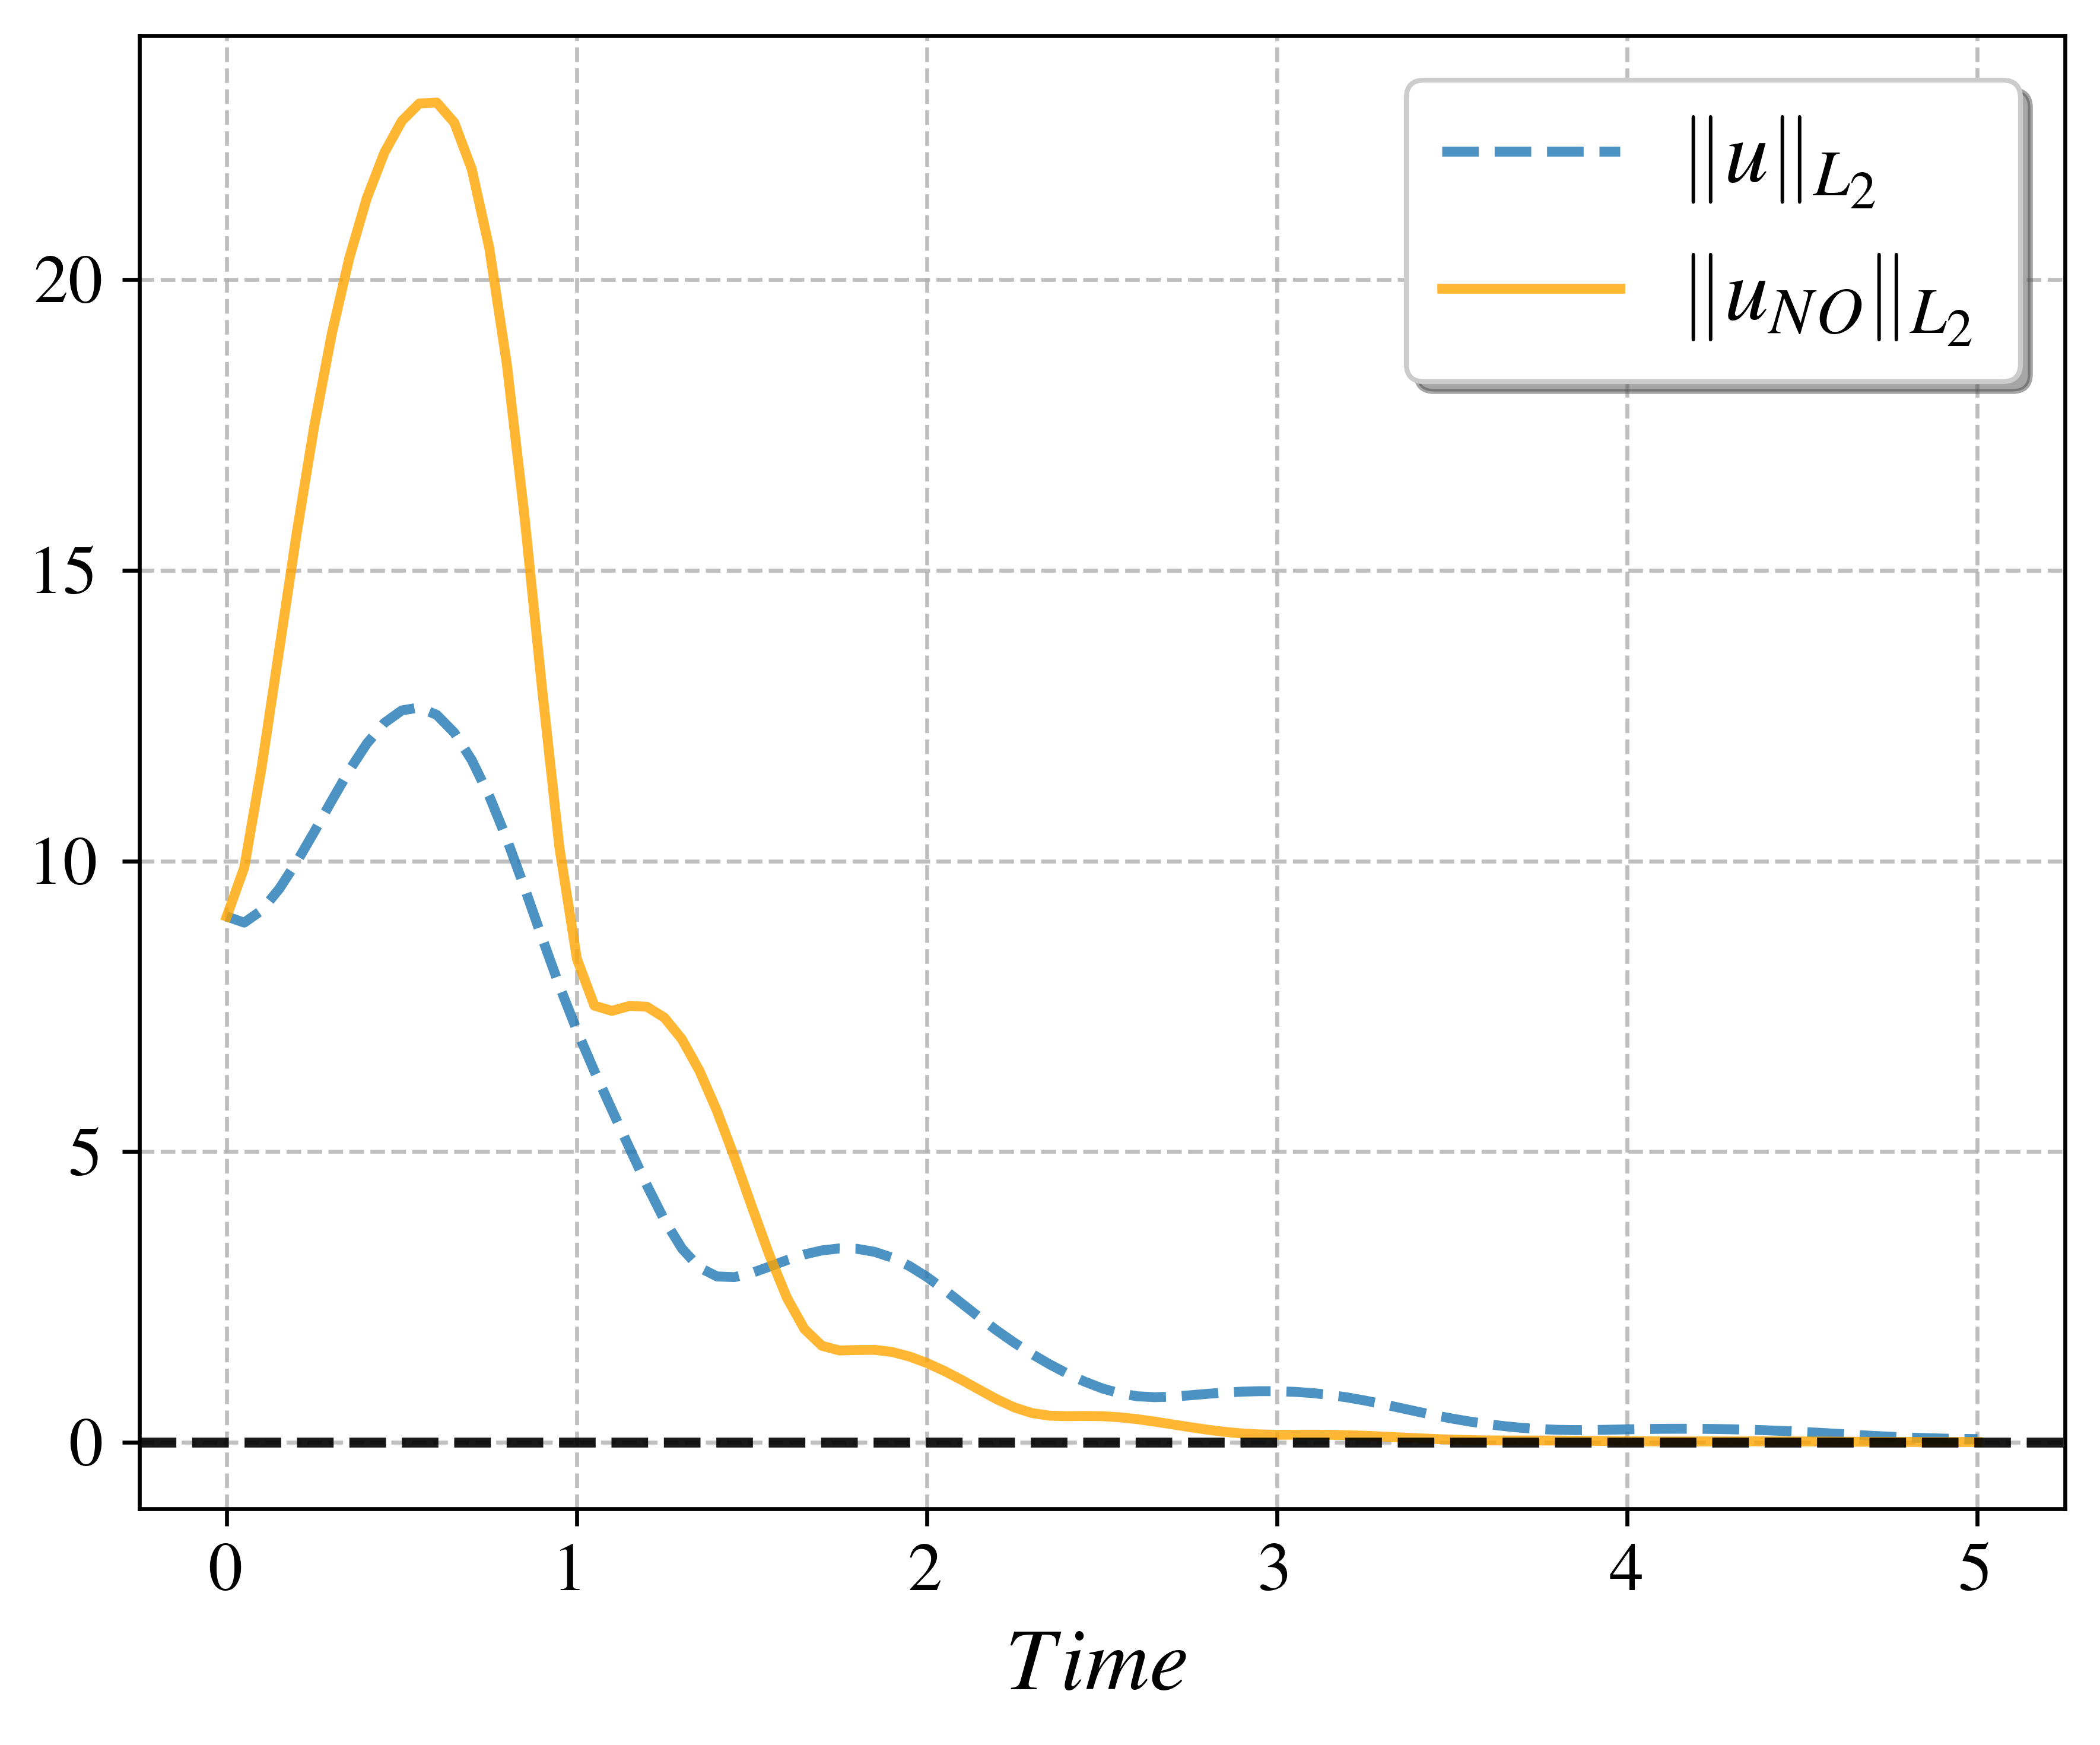

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 计算L2范数的函数
def compute_l2_norm(u, dx):
    """
    计算状态场u在每个时间步的L2范数
    :param u: 状态场数组，形状为 [时间步数, 空间网格点数]
    :param dx: 空间步长
    :return: 每个时间步的L2范数数组，形状为 [时间步数]
    """
    return np.sqrt(np.sum(u ** 2, axis=1) * dx)

# 计算U3（uNO对应的状态）和U31（u对应的状态）的L2范数
l2_uNO = compute_l2_norm(uNO, dx)
l2_u = compute_l2_norm(u, dx)

# 生成时间轴
temporal = np.linspace(0, 5, len(u))

# 绘制L2范数对比图
plt.figure(figsize=(6, 5),dpi=600)
plt.plot(temporal, l2_u, label='$\|u\|_{L_2}$', linestyle='--', linewidth=2, alpha=0.8)
plt.plot(temporal, l2_uNO, label='$\|u_{NO}\|_{L_2}$', color='orange', linewidth=2, alpha=0.8)


# 添加纵轴0位置的虚线
plt.axhline(y=0, color='black', linestyle='--', alpha=0.9, linewidth=2)

# 设置坐标轴标签和字体大小
plt.xlabel(r"$Time$", fontsize=18, fontweight='bold', labelpad=5)
#plt.ylabel(r"$L_2\ \text{Norm of Difference}$", fontsize=14, fontweight='bold', labelpad=5)

# 刻度标签加粗
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')


# 显示图例（带阴影和边框）
plt.legend(fontsize=18, frameon=True, shadow=True)

# 添加背景网格
plt.grid(True, linestyle='--', alpha=0.8)

# 添加标题并调整布局
#plt.title("L2 Norm of State Comparison", fontsize=16)
plt.tight_layout()
#plt.title('u(x,0)=9-lam=5.5')
# 显示图形
plt.show()